<h1>ASSIGNMENT 8 : Decision Trees on Amazon Fine Food Reviews</h1>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

<strong> OBJECTIVES :</strong>
    - Featurization/ Vectorization : Bow, tf-idf, avg w2v, tf-idf w2v
    - Train & Test Split : Time based slicing (70:30)
    - Cross validation : optimal depth for each Vectorization
    - Test accuracy,f1 score,precsion,confusion matrix applied on all vectorization
    - Optimal C Techniques : GridSearchCV 

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [57]:
# Loading Pre-Processed data( Reviews ) from database
conn = sqlite3.connect('final_database.sqlite')
data = pd.read_sql_query('''SELECT * FROM Reviews''',conn)

In [58]:
data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [59]:
# Sorting data in ascending order wrt time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by = "Time")

In [60]:
data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


In [61]:
data["Score"].value_counts()

positive    307061
negetive     57110
Name: Score, dtype: int64

In [62]:

def Partition(x):
    if x == "positive":
        return 1
    else:
        return 0
    
actual_score = data['Score']
pone = actual_score.map(Partition)
data['Score'] = pone

data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


In [63]:
data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [64]:
X = data["CleanText"]
y = data["Score"]

In [65]:
#Splitting sampe data in train and test dataset in  70:30
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
#encoded_labels =data["Score"].map(lambda x: 1 if x == 'positive' else 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 0)
print(X_train.shape, X_test.shape)

(254919,) (109252,)


In [66]:
#Sampling 100k data pts in 70:30 train test

X_tr = X_train.iloc[1:70001]
y_tr = y_train.iloc[1:70001]
Xt = X_test.iloc[1:30001]
yt = y_test.iloc[1:30001]

print(X_tr.shape,Xt.shape)

(70000,) (30000,)


In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
Depths = [3,5,7,9,10,11,13,17]

# function to calculate hyperparameter using GridSearchCV
def DT(X_train,y_train,X_test, y_test):
    param_grid = {'max_depth': Depths}
    tscv = TimeSeriesSplit(n_splits=3)
    
    model = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=10), param_grid, scoring = 'f1_weighted', cv=tscv)
    model.fit(X_train, y_train)
    

    # Optimal value of depth
    optimal_depth = model.best_estimator_.max_depth
    print("The optimal value of depth is : ",optimal_depth)
    
    # plotting f1 score vs Depth graph 
    x=Depths
    y= model.cv_results_['mean_test_score']
    
    print(x)
    print(y)
    plt.xlabel(r"max depth",fontsize=15)
    plt.ylabel("f1-score")
    plt.title(r'F1 Score v/s Max Depth')
    plt.plot(x,y)
    plt.show()
    
    
    print(model.best_estimator_)
    print("\nF1 score is :")
    print(model.score(X_test, y_test))
    
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    print("\nConfusion Matrix :")
    print(cm)
    plt.figure()
    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("CONFUSION MATRIX ")
    
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    print('\n****Test accuracy  is %d%%' % (acc))
    
    prs = precision_score(yt, pred, average='weighted')
    print("\nprecision score is "+str(prs))
    
    rcs = recall_score(yt, pred, average='weighted')
    print("\nrecall score is "+str(rcs))

In [68]:
#function to find top feaures
def show_most_informative_features(vectorizer,d,n=25):
   
    DT = DecisionTreeClassifier(max_depth=d,min_samples_leaf=10, min_samples_split=10)
    DT.fit(Xtr,y_tr)

    # Calculate feature importances from decision trees
    importances = DT.feature_importances_

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1][:25]

    # Rearrange feature names so they match the sorted feature importances
    names = vectorizer.get_feature_names()
    
    for i in indices :
        print(names[i])

<h3>BoW</h3>

In [53]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer

In [54]:
count_vect = CountVectorizer()
X_tr = count_vect.fit_transform(X_tr)
Xt = count_vect.transform(Xt)

In [55]:
print("the type of count vectorizer ",type(X_tr))
print("the shape of out text BOW vectorizer ",X_tr.get_shape())
print("the number of unique words ", X_tr.get_shape()[1])

print("the shape of out text BOW vectorizer ",Xt.get_shape())
print("the number of unique words ", Xt.get_shape()[1])

print("the shape of out text BOW vectorizer ",Xt.get_shape())
print("the number of unique words ", Xt.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 61998)
the number of unique words  61998
the shape of out text BOW vectorizer  (30000, 61998)
the number of unique words  61998
the shape of out text BOW vectorizer  (30000, 61998)
the number of unique words  61998


The optimal value of depth is :  17
[3, 5, 7, 9, 10, 11, 13, 17]
[0.81177122 0.82295194 0.82587909 0.82956427 0.83138338 0.83224381
 0.83482168 0.83959718]


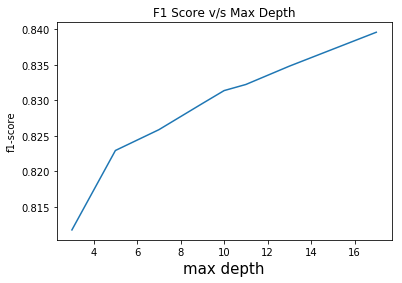

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

F1 score is :
0.8437290817268409

Confusion Matrix :
[[ 1479  3272]
 [  794 24455]]

****Test accuracy  is 86%

precision score is 0.8453604306232725

recall score is 0.8644666666666667


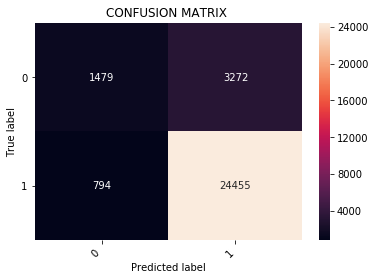

In [46]:
DT(X_tr,y_tr,Xt,yt)

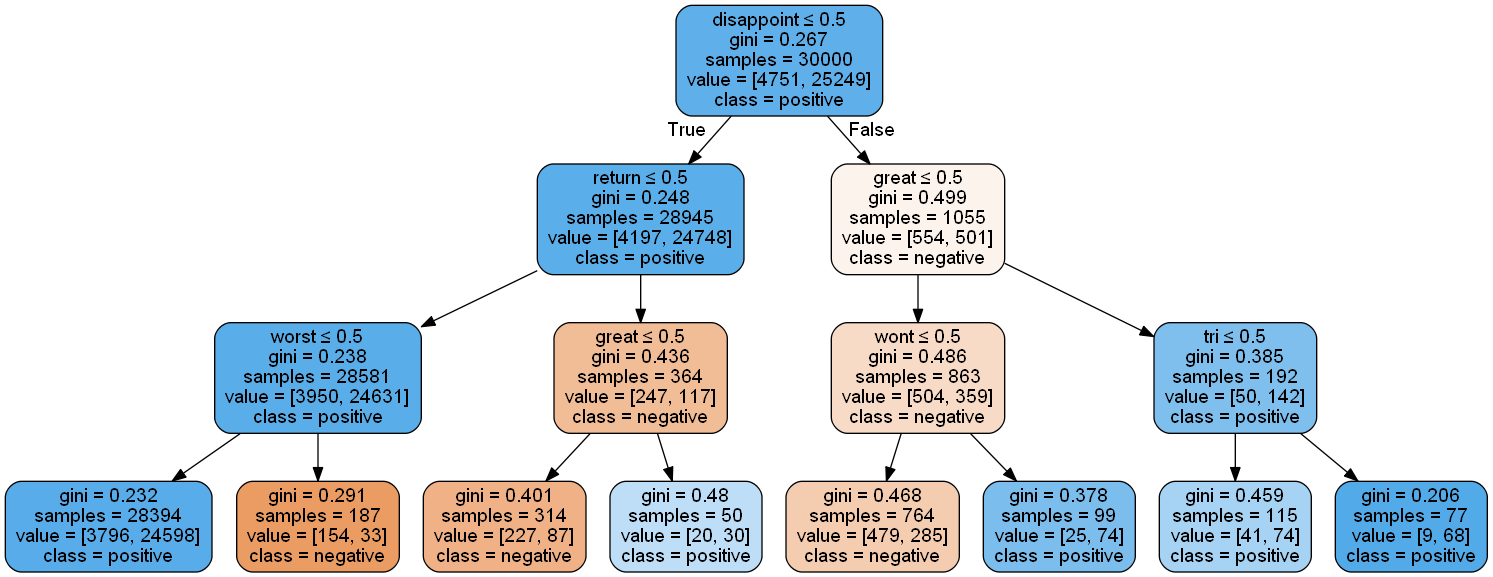

In [56]:
#Visualize tree
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=10)
dt.fit(Xt,yt)
importances = dt.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()
target = ['negative','positive']

# Create DOT data
data = tree.export_graphviz(dt,out_file=None,feature_names=names,class_names=target,filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

<strong>top 25 important features</strong>

In [170]:
show_most_informative_features(count_vect,17)

disappoint
great
return
wast
love
best
worst
terribl
aw
delici
horribl
good
bad
perfect
excel
favorit
money
unfortun
descript
tast
thought
threw
disgust
wont
refund


<h3>TF-IDF</h3>

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()
Xtr = tf_idf_vect.fit_transform(X_tr)
X_t = tf_idf_vect.transform(Xt)

The optimal value of depth is :  17
[3, 5, 7, 9, 10, 11, 13, 17]
[0.81422826 0.82374547 0.8254451  0.83067516 0.83396096 0.83384424
 0.83308622 0.83675734]


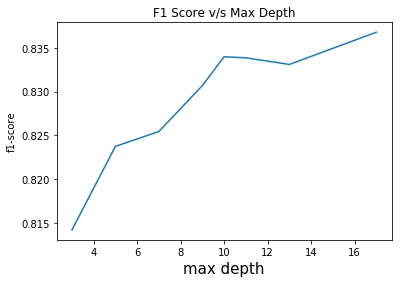

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

F1 score is :
0.8384029864014652

Confusion Matrix :
[[ 1318  3433]
 [  683 24566]]

****Test accuracy  is 86%

precision score is 0.842750867096542

recall score is 0.8628


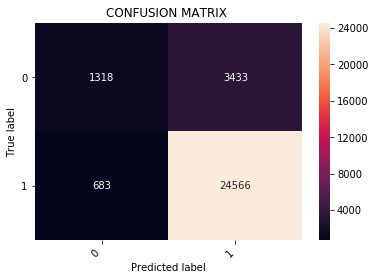

In [58]:
DT(Xtr,y_tr,X_t,yt)

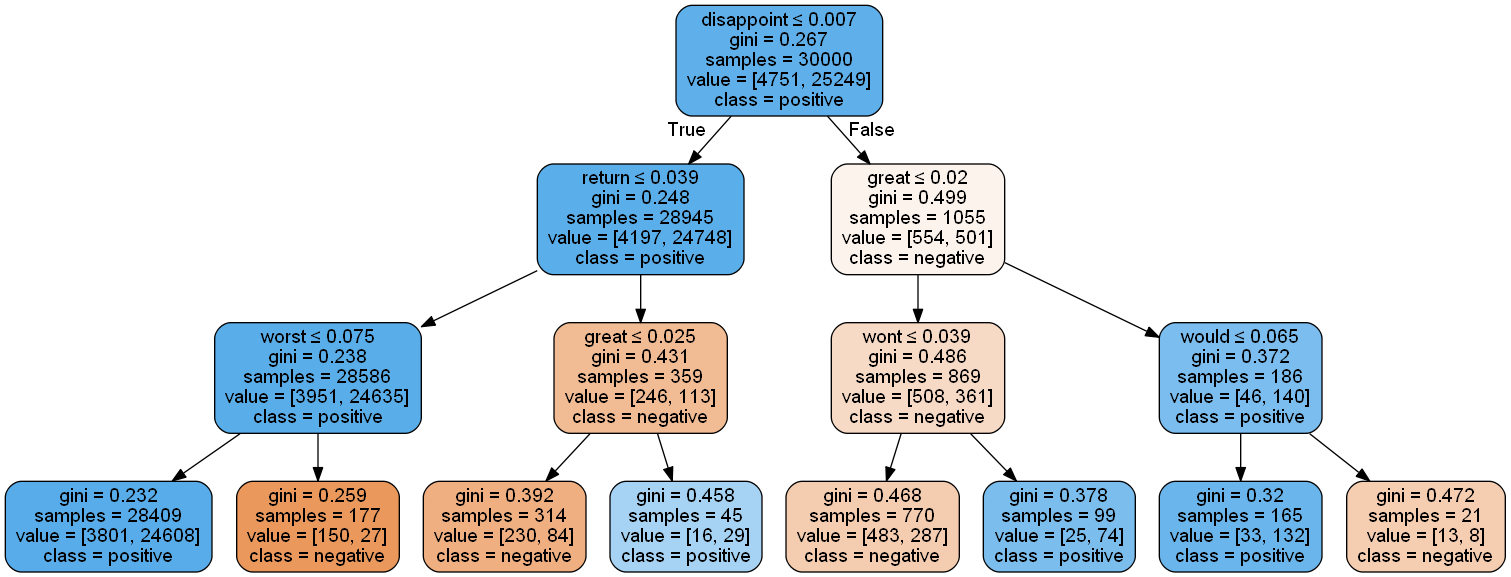

In [70]:
#Visualize tree
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=10)
dt.fit(X_t,yt)
importances = dt.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = tf_idf_vect.get_feature_names()
target = ['negative','positive']

# Create DOT data
data = tree.export_graphviz(dt,out_file=None,feature_names=names,class_names=target,filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

<strong>Top 25 features</strong>

In [183]:
show_most_informative_features(tf_idf_vect,17)

disappoint
great
return
love
wast
worst
best
bad
good
delici
terribl
tast
aw
perfect
horribl
favorit
excel
descript
money
refund
unfortun
tri
threw
find
thought


<h3>word2vec</h3>

In [89]:
# Trainning Word2Vec model using own text corpus
i=0
list_of_sent=[]
for sent in X_tr.values: 
    list_of_sent.append(sent.split())

In [90]:
# Trainning Word2Vec model using own text corpus
i=0
list_of_sent_test=[]
for sent in Xt.values: 
    list_of_sent_test.append(sent.split())

In [91]:
# min_count = 5 considers only words that occured atleast 5 times
import warnings
warnings.filterwarnings("ignore")

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=3)

In [92]:
w2v_words = list(w2v_model.wv.vocab)

<h3>Average Word2Vec </h3>

In [73]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [74]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [75]:
X_tr = sent_vectors
Xt = sent_vectors_test

The optimal value of depth is :  7
[3, 5, 7, 9, 10, 11, 13, 17]
[0.82638713 0.83193985 0.84303406 0.84283299 0.8383944  0.83786379
 0.83477174 0.83339926]


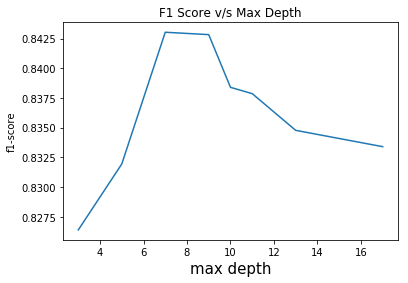

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

F1 score is :
0.8467791736539364

Confusion Matrix :
[[ 1718  3033]
 [ 1115 24134]]

****Test accuracy  is 86%

precision score is 0.8437084224377428

recall score is 0.8617333333333334


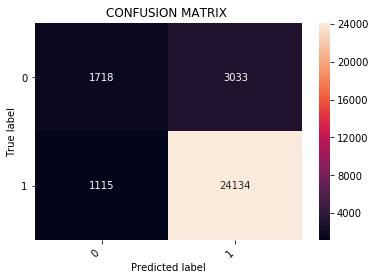

In [76]:
DT(X_tr,y_tr,Xt,yt)

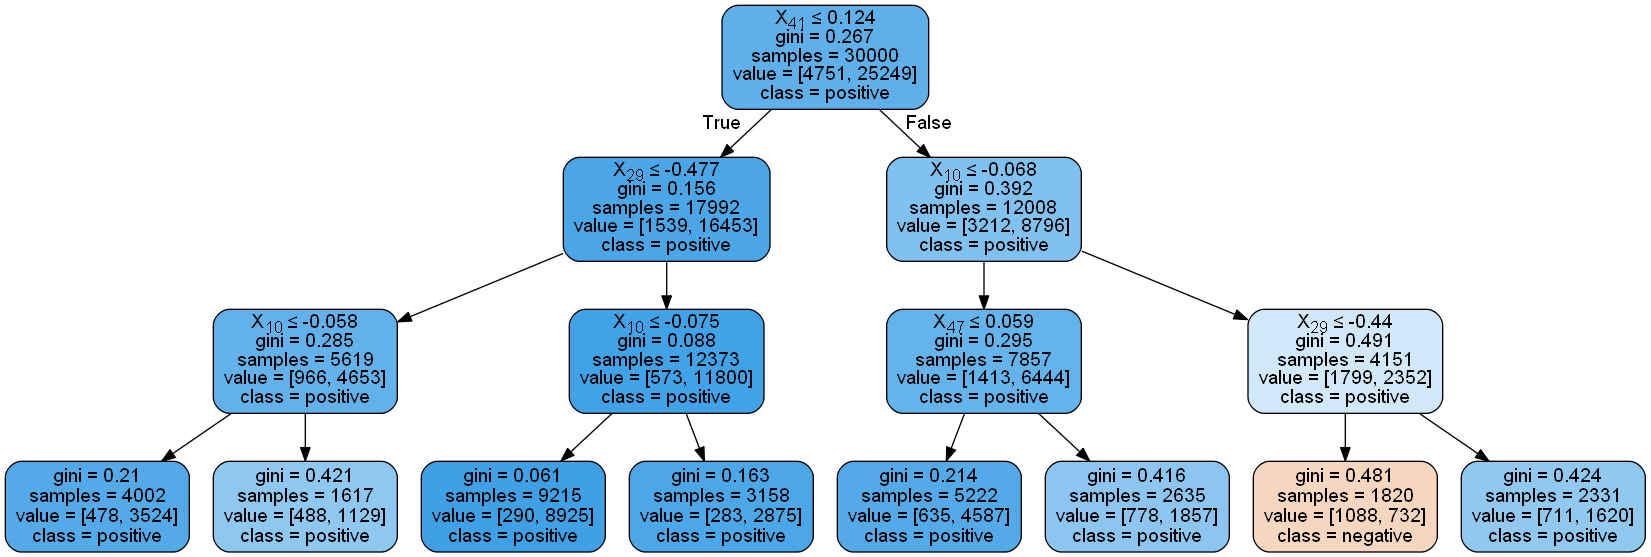

In [77]:
#Visualize tree
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=5)
dt.fit(Xt,yt)
target = ['negative','positive']
# Create DOT data
data = tree.export_graphviz(dt,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

<h3>Tf-Idf Word2Vec </h3>

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [94]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
from tqdm import tqdm

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:27<00:00, 473.86it/s]


In [95]:
train = tfidf_sent_vectors

In [96]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
from tqdm import tqdm

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:01<00:00, 484.61it/s]


In [97]:
test = tfidf_sent_vectors_test

The optimal value of depth is :  9
[3, 5, 7, 9, 10, 11, 13, 17]
[0.77187298 0.8035523  0.81976672 0.82414884 0.82335652 0.8214569
 0.81831336 0.81610849]


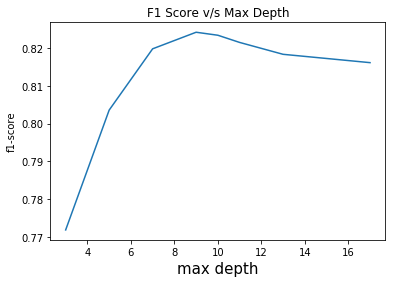

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

F1 score is :
0.8270906767022397

Confusion Matrix :
[[ 1436  3315]
 [ 1352 23897]]

****Test accuracy  is 84%

precision score is 0.8206735620073795

recall score is 0.8444333333333334


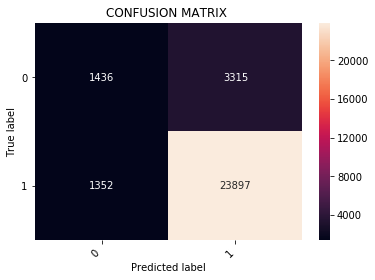

In [98]:
DT(train,y_tr,test,yt)

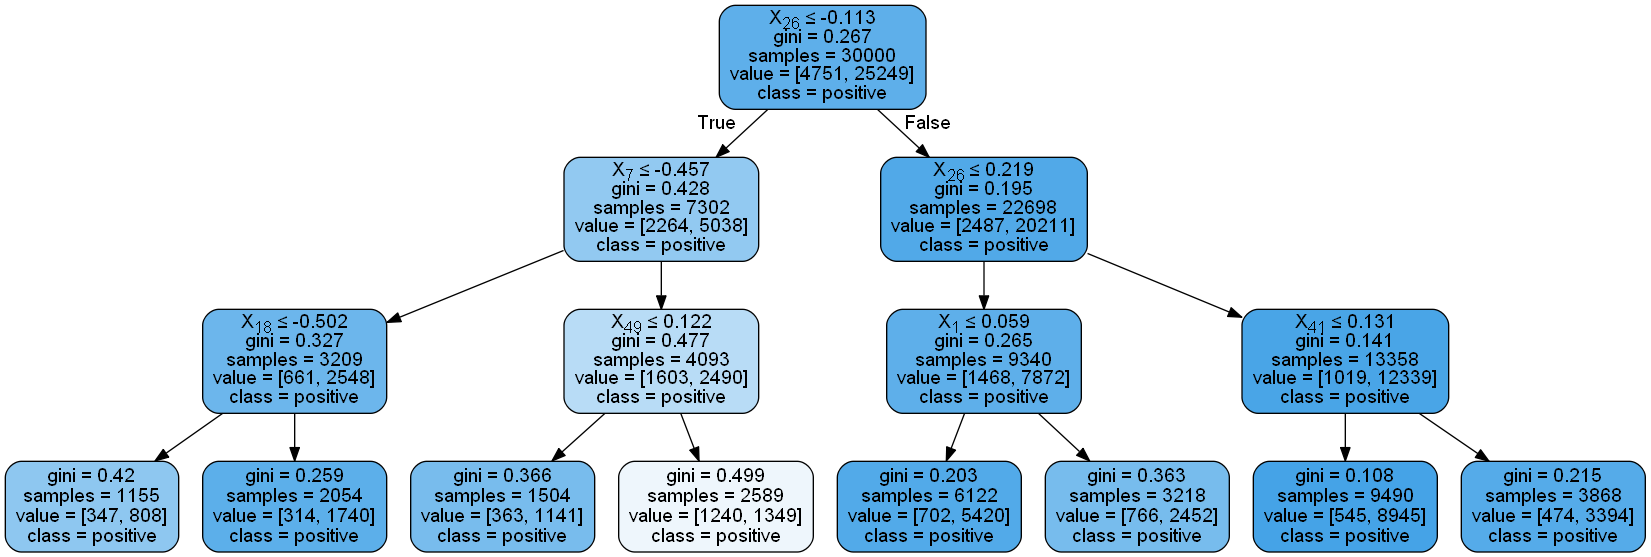

In [99]:
#Visualize tree
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=10)
dt.fit(test,yt)
target = ['negative','positive']
# Create DOT data
data = tree.export_graphviz(dt,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

<h2>Conclusion</h2>

Here we have considered 100k data points

In [113]:
table = {'Technique':['BoW', "TFIDF","Avg_w2v","tf-idf_w2v"],'F1 score':[0.8436,0.8393,0.8284,0.8297],'depth ':[17,17,7,9],'min_samples_leaf':[10,10,10,10],'min_samples_split':[10,10,5,10] }
df = pd.DataFrame(data=table)
df

,Technique,F1 score,depth,min_samples_leaf,min_samples_split
0,BoW,0.8436,17,10,10
1,TFIDF,0.8393,17,10,10
2,Avg_w2v,0.8284,7,10,5
3,tf-idf_w2v,0.8297,9,10,10


    -BoW & tfidf performed well in Decision Tree Classifier.
    -Tfidf w2v didnt performed well.
    -Decision Tree Classifer is comparative fast.
    -We have fixed min leaf size and min split size so to avoid overfitting.